In [20]:
from contextGenerator import LuceneRetrieval
from sklearn.feature_extraction.text import TfidfVectorizer
import torch 
import numpy as np
import timeit
from dataclasses import dataclass
import seaborn as sns
import matplotlib.pyplot as plt
import re 
from datasets import load_from_disk
import pandas as pd
import os
import utils
import spacy
import math

vectorizer = TfidfVectorizer() 
nlp = spacy.load("en_core_web_lg")

ds = load_from_disk("../res/data/guessTrain")
searcher = LuceneRetrieval()
df = ds['validation'].to_pandas()


Dec 28, 2024 2:08:08 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


# Optimizing document retreival 
The task is to retrieve documents in response to a given question, ensuring that the retrieved document contains the answer to the question. Depending on the model implementation, multiple documents may be retrieved to increase the likelihood of finding the answer. However, for the purposes of this exploration, the primary focus is on the worst-case scenario: retrieving a single document. This setting serves as the baseline for evaluation.

Additionally, while the full question provides the most information, it is not optimal for model performance. If the model waits until the entire question is revealed to make a guess, it indicates suboptimal performance. Therefore, exploring variations in the amount of the question provided is crucial to balance information availability and timely decision-making.

Key metrics to consider include accuracy, response time, and run length. For each run depth—that is, the number of sentences revealed—these metrics should be measured and analyzed to evaluate performance.
### Pyserini retrieval
Our project utilizes the Pyserini package, an retrieval toolkit. The most cost-efficient retrieval method is a traditional lexical model using BM25. BM25 is a ranking algorithm specifically designed for retrieval tasks and follows a bag-of-words approach. This means that it does not account for the order or relationships between terms within a document. For example, even if the words in a document are shuffled, BM25 treats it as the same document.

However, some relationships can be approximated using techniques like n-gram tokenization, where sequences of two or more consecutive words (e.g., bigrams or trigrams) are added to the corpus vocabulary. While this captures some word relationships, these extended vocabularies still lack explicit semantic connections between terms.

BM25 Key Considerations
1. Term Frequency (TF):
    1. The frequency of query terms appearing in a document directly impacts the score.
2.	Inverse Document Frequency (IDF):
	1. Common terms across the corpus are weighted lower, while rarer terms are given more importance.
3. Document Length Normalization:
	1. Ensures that longer documents do not dominate smaller ones by scaling term scores relative to document length. This adjustment prevents longer documents from being unfairly prioritized.


### Designign the query
When designing a query optimized for BM25, it is crucial to ensure that all terms are meaningful and contribute significant informational value. In the context of a bag-of-words model, some words lose much of their informational importance. For example adjectives, conjunctions, and other similar words will be esentially meaningless.

For example, consider the sentence:
“Usain Bolt is a Jamaican retired sprinter who is widely considered to be the greatest sprinter of all time.”

Terms like ‘is’ and ‘of all time’ provide essential contextual information in a full sentence. However, within a bag-of-words framework, these terms contribute little value. Furthermore, BM25’s Inverse Document Frequency (IDF) scaling reduces the weight of common terms, rendering their contribution to the final score negligible.

Instead, focusing on key terms such as ‘Usain Bolt,’ ‘Jamaican,’ ‘retired,’ and ‘sprinter’ filters out noise and prioritizes the most meaningful elements. These terms are more likely to appear in relevant documents and are less common overall, especially in combination. By eliminating less informative words, we can refine the query, reduce the impact of irrelevant terms, and emphasize the core elements of interest.

The most informational terms are typically:
1.	Named Entities: Names, titles, locations, etc., that are specific and rare in the corpus.
2.	Nouns and Verbs: Content-heavy words that often convey the main ideas.

Further preprocessing can be employed to refine the information within the query. Techniques such as accent removal, stemming, and lemmatization are effective in normalizing words to their root forms. This normalization enables more matches to be identified by reducing variations in word forms. For instance, words like running, ran, and runs can all be reduced to their root form, run, improving retrieval consistency. However, implementing these techniques comes with a trade-off in computational expense. To achieve effective matching, the same preprocessing must also be applied to the entire corpus, which can be computationally intensive, especially for large-scale datasets. Despite the cost, such preprocessing can significantly enhance the efficiency and accuracy of BM25 by reducing noise and increasing the likelihood of identifying relevant documents.

In [173]:
# function that will check if a context contains the answer 
width = 4


def generate_run(sentence: str):
    return sentence.split('.')

def mean_ign_rows(mtx):
    curr = torch.zeros([1,width])    
    for x in mtx:
        curr = sum_ign_rows(curr, x)
    for i, x in enumerate(curr):
        curr[i, :-1] = x[0:-1]/x[3]
    return curr
        
        

def sum_ign_rows(mtx1, mtx2):
    len1 = len(mtx1)
    len2 = len(mtx2)
    
    if len1 > len2:
        return torch.cat((mtx2, torch.zeros([len1 - len2, width])), 0) + mtx1
    elif len1 < len2:
        return torch.cat((mtx1, torch.zeros([len2 - len1, width])), 0) + mtx2
    return mtx1 + mtx2



context = None
def ret_eval(row, strategy):
    
    answer = row['answer']
    question = row['full_question']
    '''[contains, time, run length, freq] for each split'''
    splits = nlp(question)
    splits = [sent.text for sent in splits.sents]
    mtx = torch.zeros((len(splits), width)) 
    agg_run = ""

    for i, run in enumerate(splits):  
        agg_run = ' '.join([agg_run, run])   
        timer = timeit.Timer(lambda: strategy(agg_run))
        mtx[i][1]  = timer.timeit(1)
        mtx[i][2] = len(agg_run.split(' '))
        mtx[i][3]  = 1
        if str(answer).lower() in str(context).lower():
            mtx[i][0] = 1
    return mtx

## Strategy 1: Whole Run Similarity
Baseline strategy: Retrieve the most similar document based on the full content of the question. This approach includes all the noise, which may increase the computational cost of identifying related documents. However, it is unclear whether the presence or absence of noisy terms affects accuracy, or how the overhead of handling noise compares to the overhead of removing terms from the vocabulary or tokenizing the query to extract entities.

In [172]:
def whl_run(run):
    global context
    try:
        context = searcher(run, 1)[0]['contents']
    except:
        context = "No doc"
    
df['strat_1'] = df.apply(lambda row: ret_eval(row, whl_run), axis = 1)

In [174]:
agg_eval_1 = mean_ign_rows(df['strat_1'])  
columns = ['accuracy', 'time', 'run_length', 'sentence_depth_freq'] 
agg_eval_1 = pd.DataFrame(agg_eval_1, columns=columns)
agg_eval_1['num_of_clues'] = agg_eval_1.index + 1

## Strategy 2: Preprocessed Whole Run Similarity
Similar to the baseline strategy, this approach involves reducing and cleaning the query while retaining much of the vocabulary. Specifically, it will lowercase all text, apply stemming and lemmatization, remove stopwords such as “and” and “it,” and eliminate superfluous punctuation. After processing, it will retrieve the most similar document based on the full content of the cleaned query. Aims to evaluate the cost of cleaning the query and to assess whether there is any valuable information in the typically non-informative terms.

In [175]:
def prc_whl_run(run):
    global context
    run = utils.clean_text(run)
    try:
        context = searcher(run, 1)[0]['contents']
    except:
        context = "No doc"
    
df['strat_2'] = df.apply(lambda row: ret_eval(row, prc_whl_run), axis = 1)

In [176]:
agg_eval_2 = mean_ign_rows(df['strat_2'])  
columns = ['accuracy', 'time', 'run_length', 'sentence_depth_freq'] 
agg_eval_2 = pd.DataFrame(agg_eval_2, columns=columns)
agg_eval_2['num_of_clues'] = agg_eval_2.index + 1

## Strategy 3: Top-n Document Retrieval
Retrieve the top n most similar documents for the entire query, then evaluate this set of similar documents using a different ranking algorithm. The goal is to determine if layering retrieval rankings can capture more information, albeit at the cost of performance.

In [177]:
def n_run_spc_sim(run): 
    global context
    corpus = [doc['contents'] for doc in searcher(run, 3)] 
    cleaned_corpus = [] 
    max_tokens = 300 
    for doc in corpus: 
        words = doc.split() 
        chunk = [] 
        for word in words: 
            if len(chunk) + 1 > max_tokens: 
                break 
            chunk.append(word) 
        cleaned_corpus.append(" ".join(chunk)) 
    tokenized_corpus = [nlp(text) for text in cleaned_corpus] 
    scores = [0] * len(tokenized_corpus) 
    for x, doc1 in enumerate(tokenized_corpus): 
        scores[x] += doc1.similarity(nlp(run)) 
    context = tokenized_corpus[np.argmax(scores)].text
df['strat_3'] = df.apply(lambda row: ret_eval(row, n_run_spc_sim), axis = 1)


In [178]:
agg_eval_3= mean_ign_rows(df['strat_3'])  
columns = ['accuracy', 'time', 'run_length', 'sentence_depth_freq'] 
agg_eval_3 = pd.DataFrame(agg_eval_3, columns=columns)
agg_eval_3['num_of_clues'] = agg_eval_3.index + 1

## Strategy 4: Per-Clue Retrieval + whole run evaluation
For each clue, retrieve the most similar document. Then, evaluate the rest of the n-document corpus to find the most similar document to the entire question. The goal is to see if focusing on a clue at a time yields more focused results for the specific clues. Given the pyramidal structure, we expect more obvious clues to appear as the question progresses. By concentrating on individual clues, we may be able to avoid superfluous information. Afterward, by comparing the new corpus against the entire question, we can identify which specialized document contains the most overlap.

In [179]:
def per_clue(run): 
    global context
    quest_splits = nlp(run)
    quest_splits = [sent.text for sent in quest_splits.sents]
    corpus = [searcher(x, 1)[0] for x in quest_splits]   

    corpus = [x['contents'] for x in corpus]    
    
    cleaned_corpus = [] 
    max_tokens = 300 
    for doc in corpus: 
        words = doc.split() 
        chunk = [] 
        for word in words: 
            if len(chunk) + 1 > max_tokens: 
                break 
            chunk.append(word) 
        cleaned_corpus.append(" ".join(chunk)) 
    
    tokenized_corpus = [nlp(text) for text in cleaned_corpus] 
    tok_quest = nlp(run)
    scores = [x.similarity(tok_quest) for x in tokenized_corpus]
    context = corpus[np.argmax(scores)]
    
df['strat_4'] = df.apply(lambda row: ret_eval(row, per_clue), axis = 1)

/var/folders/qy/2q9gjn1n6h717qx1g0ky69700000gn/T/ipykernel_18583/1917522791.py:22: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  scores = [x.similarity(tok_quest) for x in tokenized_corpus]


In [180]:
agg_eval_4= mean_ign_rows(df['strat_4'])  
columns = ['accuracy', 'time', 'run_length', 'sentence_depth_freq'] 
agg_eval_4 = pd.DataFrame(agg_eval_4, columns=columns)
agg_eval_4['num_of_clues'] = agg_eval_4.index + 1
agg_eval_4.head(10)

,accuracy,time,run_length,sentence_depth_freq,num_of_clues
0,0.370616,0.055297,23.559242,1055.0,1
1,0.436967,0.103670,45.359241,1055.0,2
2,0.490047,0.151123,67.141235,1055.0,3
3,0.560721,0.196947,88.648956,1054.0,4
4,0.600966,0.239765,107.774879,1035.0,5
5,0.626214,0.275566,121.160194,824.0,6
6,0.662132,0.304060,129.505676,441.0,7
7,0.647059,0.323235,131.210083,119.0,8
8,0.678571,0.340064,131.142853,28.0,9
9,0.833333,0.359079,124.833336,6.0,10


## Strategy 5: Named Entity-Based Retrieval
For each clue, extract named entities and retrieve documents based on their frequency of occurrence in the corpus. Select the document with the highest overall frequency of the named entities as the most relevant. Aims to see if the most reduction is possivble in repects to maintaining information and keeping costs low. 

In [181]:
def ner_ret(run): 
    global context
    tok = nlp(run)
    ents = [x.text for x in tok.ents]
    for toks in tok:
        if toks.pos_ == 'NOUN':
            ents.append(toks.text)
        
    agg_ents = ". ".join(ents)
    context = (searcher(agg_ents, 1)[0]['contents'])

    
df['strat_5'] = df.apply(lambda row: ret_eval(row, ner_ret), axis = 1)

In [182]:
agg_eval_5= mean_ign_rows(df['strat_5'])  
columns = ['accuracy', 'time', 'run_length', 'sentence_depth_freq'] 
agg_eval_5 = pd.DataFrame(agg_eval_5, columns=columns)
agg_eval_5['num_of_clues'] = agg_eval_5.index + 1
agg_eval_5['id'] = agg_eval_5.index
agg_eval_5.head(10)

,accuracy,time,run_length,sentence_depth_freq,num_of_clues,id
0,0.326066,0.010464,23.559242,1055.0,1,0
1,0.466351,0.020201,45.359241,1055.0,2,1
2,0.575355,0.030710,67.141235,1055.0,3,2
3,0.693548,0.039973,88.648956,1054.0,4,3
4,0.784541,0.047571,107.774879,1035.0,5,4
5,0.820388,0.051767,121.160194,824.0,6,5
6,0.848073,0.051597,129.505676,441.0,7,6
7,0.865546,0.048409,131.210083,119.0,8,7
8,0.821429,0.039364,131.142853,28.0,9,8
9,0.833333,0.048808,124.833336,6.0,10,9


# Analysis

In [165]:
agg_eval_1['strat'] = "Whole_Run" 
agg_eval_2['strat'] = "Processed_Whole_Run"
agg_eval_3['strat'] = "N_Doc"
agg_eval_4['strat'] = "Per_Clue"
agg_eval_5['strat'] = "NER"

avg_eval = pd.concat([agg_eval_1,agg_eval_2,agg_eval_3,agg_eval_4,agg_eval_5], sort = True)

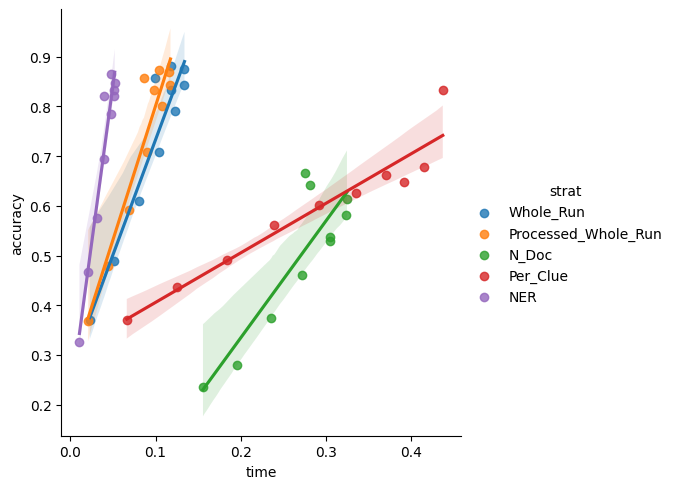

In [186]:
# Accuracy vs. Time:
g = sns.lmplot(
    data=avg_eval,
    x="time", y="accuracy", hue="strat",
    height=5
)

We can see that only one strategy significantly lagged behind the others in terms of accuracy: the N_Doc strategy. However, this may be mitigated if the layered ranking were better designed, though the time expense seems unavoidable, making further refinement seem less promising. On the other hand, the NER strategy performed exceptionally well, achieving accuracy very similar to both the baseline and processed strategies, but with significantly less time spent.

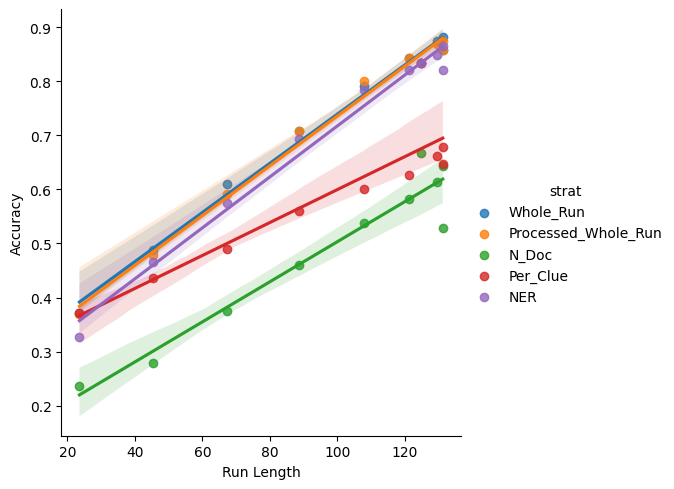

In [167]:
# Run Length vs. Accuracy
p2 = sns.lmplot(
    data=avg_eval,
    x="run_length", y="accuracy", hue="strat",
    height=5
)
p2.set_axis_labels("Run Length", "Accuracy")
plt.show() 

Once again, we observe that the accuracy remains highly competitive between our top prospects. However, NER showed significantly more variance as the run length increased, a trend also seen in the Per_clue and N_doc strategies. This is likely due to the smaller sample size of questions of this size. Although it is slightly difficult to discern, at the same run lengths within our top three strategies, a consistent pattern emerges: NER is always just slightly behind the others. This is likely due to how aggressively we are reducing the size of our query. Whether the time costs outweigh the very small accuracy loss seems reasonable to consider.

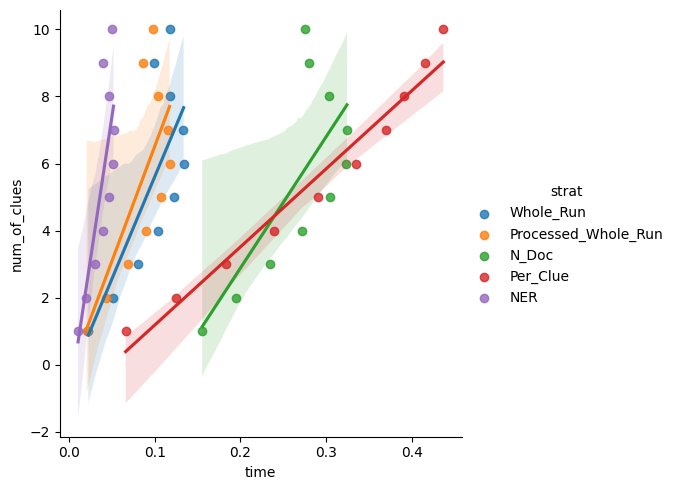

In [169]:
# # Time vs. Strat
g = sns.lmplot(
    data=avg_eval,
    x="time", y="num_of_clues", hue="strat",
    height=5
)
plt.show()

NER is performaing extremetly well consistently in respect to time. 

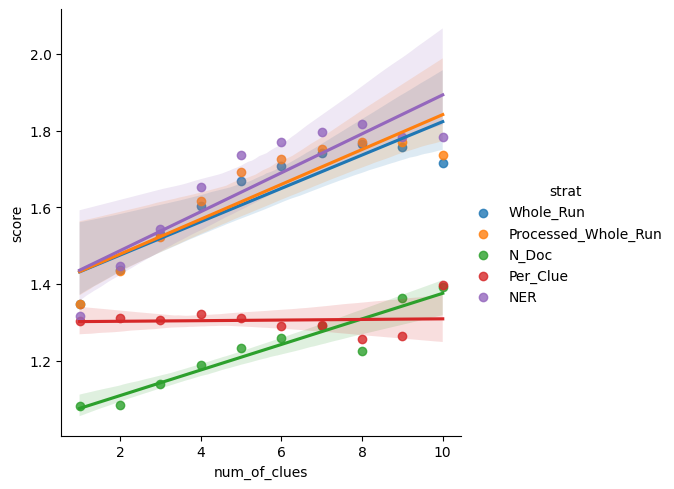

In [184]:
# score = time to be low, acc to be high, num_clues/run length low,    
w_1 = 1
w_2 = 1
avg_eval['score'] = avg_eval.apply(lambda x: x['accuracy']+ (1-x['time']), axis= 1)
g = sns.lmplot(
    data=avg_eval,
    x="num_of_clues", y="score", hue="strat",
    height=5
)
plt.show()

This score aims to highlight strategies that have low times, high accuracy, and achieve both of these as quickly as possible in relation to how much of the question has been revealed. The weight can be adjusted to emphasize either time or accuracy, but from the visualization, we can see that NER performs the best.

In [195]:
def n_ner_ret(n, run): 
    global context
    tok = nlp(run)
    ents = [x.text for x in tok.ents]
    for toks in tok:
        if toks.pos_ == 'NOUN':
            ents.append(toks.text)
        
    agg_ents = ". ".join(ents)
    context = searcher(agg_ents, n)

def n_ret_eval(n, row, strategy):
    
    answer = row['answer']
    question = row['full_question']
    '''[contains, time, run length, freq] for each split'''
    splits = nlp(question)
    splits = [sent.text for sent in splits.sents]
    mtx = torch.zeros((len(splits), width)) 
    agg_run = ""

    for i, run in enumerate(splits):  
        agg_run = ' '.join([agg_run, run])   
        timer = timeit.Timer(lambda: strategy(n, agg_run))
        mtx[i][1]  = timer.timeit(1)
        mtx[i][2] = len(agg_run.split(' '))
        mtx[i][3]  = 1
        for x in range(n):
            if str(answer).lower() in str(context[x]['contents']).lower():
                mtx[i][0] = 1
    return mtx

In [200]:
avg_eval = None
for i in range(1,6):
    temp = df.apply(lambda row: n_ret_eval(i, row, n_ner_ret), axis = 1)
    temp= mean_ign_rows(temp)  
    columns = ['accuracy', 'time', 'run_length', 'sentence_depth_freq'] 
    temp = pd.DataFrame(temp, columns=columns)
    temp['num_of_clues'] = temp.index + 1
    temp['id'] = temp.index

    temp['strat'] = str(i) + "_doc_NER" 
    avg_eval = pd.concat([avg_eval, temp], sort = True)
avg_eval.head(10)

,accuracy,id,num_of_clues,run_length,sentence_depth_freq,strat,time
0,0.326066,0,1,23.559242,1055.0,1_doc_NER,0.009641
1,0.466351,1,2,45.359241,1055.0,1_doc_NER,0.019612
2,0.575355,2,3,67.141235,1055.0,1_doc_NER,0.029961
3,0.693548,3,4,88.648956,1054.0,1_doc_NER,0.039020
4,0.784541,4,5,107.774879,1035.0,1_doc_NER,0.046481
5,0.820388,5,6,121.160194,824.0,1_doc_NER,0.050483
6,0.848073,6,7,129.505676,441.0,1_doc_NER,0.050783
7,0.865546,7,8,131.210083,119.0,1_doc_NER,0.046555
8,0.821429,8,9,131.142853,28.0,1_doc_NER,0.038838
9,0.833333,9,10,124.833336,6.0,1_doc_NER,0.048696


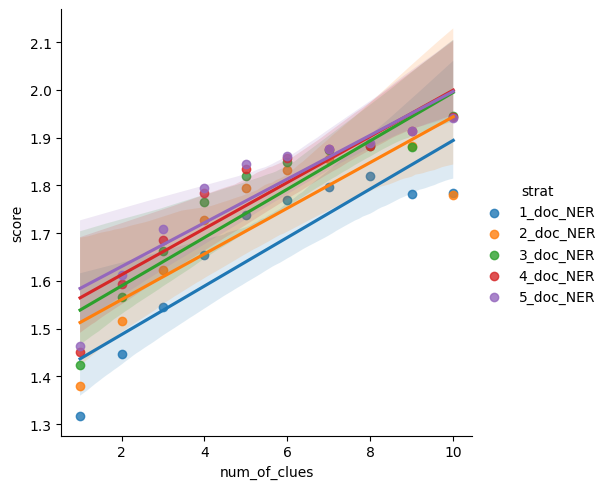

In [206]:
# score = time to be low, acc to be high, num_clues/run length low,    
w_1 = 1
w_2 = 1
avg_eval['score'] = avg_eval.apply(lambda x: x['accuracy']+ (1-x['time']), axis= 1)
g = sns.lmplot(
    data=avg_eval,
    x="num_of_clues", y="score", hue="strat",
    height=5
)
plt.show()